<a href="https://colab.research.google.com/github/aaravbmb/ML-speech-emotion-recognition-system/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Speech Analysis System

In [1]:
# Importing Libraries

# General Libraries
import numpy as np
import pandas as pd
import os
import wave
import matplotlib.pyplot as plt

# Project-Specific Libraries
import librosa

from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshitapanwar2711","key":"9fda017559ec7e3426e7d7509afb5eaa"}'}

In [3]:
import os
import zipfile

# Move kaggle.json to correct folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
100% 429M/429M [00:19<00:00, 24.0MB/s]
100% 429M/429M [00:19<00:00, 22.6MB/s]


In [ ]:
!unzip ravdess-emotional-speech-audio.zip -d ravdess

In [6]:
# Extract MFCC from WAV Audio File
def extract_mfcc(wav_file_name):
  y, sr = librosa.load(wav_file_name)
  mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
  return mfccs

In [7]:
# Loading RADVESS Speech Data
radvess_speech_labels = []
radvess_speech_data = []
for dirname, _, filenmames in os.walk('/content/ravdess/'):
  for filename in filenmames:
    radvess_speech_labels.append(int(filename[7:8]) - 1)
    wav_file_name = os.path.join(dirname, filename)
    radvess_speech_data.append(extract_mfcc(wav_file_name))

In [8]:
# Converting Data and Label to Array
radvess_speech_data_array = np.array(radvess_speech_data)
radvess_speech_labels_array = np.array(radvess_speech_labels)

# Making Categorical Labels
labels_categorical = to_categorical(radvess_speech_labels_array)

In [10]:
# Splitting Data into Training and Testing Data
x_train, x_test, y_train, y_test = train_test_split(np.array(radvess_speech_data_array), labels_categorical, test_size=0.2, random_state=9)


number_of_samples = radvess_speech_data_array.shape[0]
training_samples = int(number_of_samples * 0.8)
validation_samples = int(number_of_samples * 0.1)
test_samples = int(number_of_samples * 0.1)

In [13]:
# Creating the LSTM Model
def create_model_LSTM():
  model = Sequential()
  model.add(LSTM(128, return_sequences=False, input_shape=(40,1)))
  model.add(Dense(64))
  model.add(Dropout(0.4))
  model.add(Activation('relu'))
  model.add(Dense(32))
  model.add(Dropout(0.4))
  model.add(Activation('relu'))
  model.add(Dense(8))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
  return model


In [14]:
# Training Process using LSTM Model
model_A = create_model_LSTM()
history = model_A.fit(np.expand_dims(radvess_speech_data_array[:training_samples],-1), labels_categorical[:training_samples], validation_data=(np.expand_dims(radvess_speech_data_array[training_samples:training_samples+validation_samples], -1), labels_categorical[training_samples:training_samples+validation_samples]), epochs=130, shuffle=True)

Epoch 1/130


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1420 - loss: 2.0721 - val_accuracy: 0.1806 - val_loss: 2.0343
Epoch 2/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1887 - loss: 2.0249 - val_accuracy: 0.2292 - val_loss: 1.9768
Epoch 3/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2393 - loss: 1.9592 - val_accuracy: 0.2292 - val_loss: 1.9465
Epoch 4/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2339 - loss: 1.9407 - val_accuracy: 0.2708 - val_loss: 1.9313
Epoch 5/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2800 - loss: 1.8795 - val_accuracy: 0.2569 - val_loss: 1.8943
Epoch 6/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2740 - loss: 1.8511 - val_accuracy: 0.2778 - val_loss: 1.9068
Epoch 7/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2753 - loss: 1.8460 - val_accuracy: 0.2604 - val_loss: 1.8915
Epoch 8/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2943 - loss: 1.8146 - val_accuracy: 0.2639 - val_loss: 1.

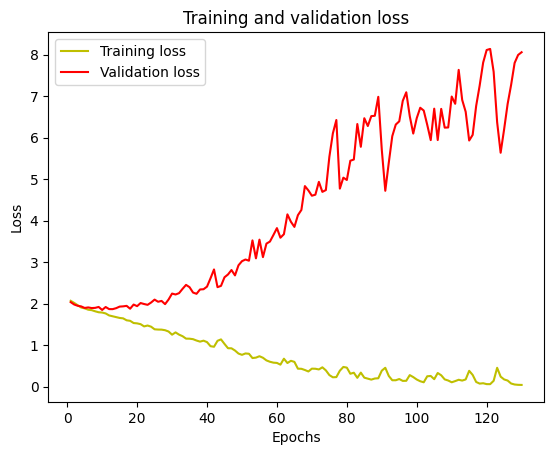

In [15]:
# Loss Plot for LSTM Model

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

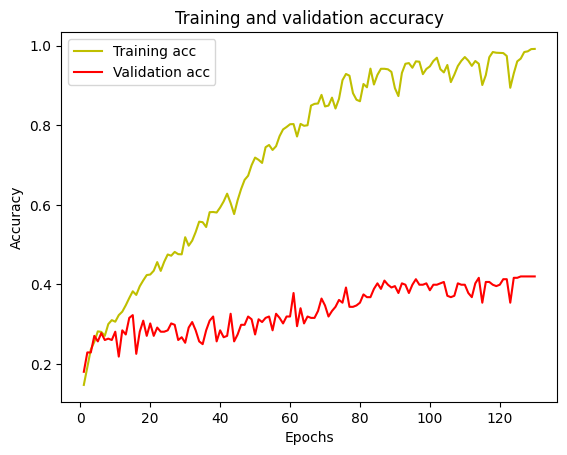

In [16]:
# Accuracy Plots using LSTM Model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# Model Evaluation
model_A.evaluate(np.expand_dims(radvess_speech_data_array[training_samples+validation_samples:], -1), labels_categorical[training_samples+validation_samples:])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6409 - loss: 5.2251 


[8.048160552978516, 0.4201388955116272]

In [19]:
# Predicting Emotions

emotions = {1 : 'neutral', 2 : 'calm', 3 : 'happy', 4 : 'sad', 5 : 'angry', 6 : 'fearful', 7 : 'disgust', 8 : 'surprised'}

def predict(wav_filepath):
  test_point = extract_mfcc(wav_filepath)
  test_point = np.reshape(test_point, newshape=(1,40,1))
  predictions = model_A.predict(test_point)
  print(emotions[np.argmax(predictions[0])+1])

In [25]:
# Testing Model using RADVESS Audio

predict('/content/ravdess/Actor_02/03-01-01-01-01-01-02.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
neutral


In [26]:
# Saving Model for Use in Streamlit Application

model_A.save('emotionrecognition.h5')